In [ ]:
'''
2. Name Entity Recognition using Transformer Encoder 
Dataset: CoNLL-2003 (NER), or a simplified custom dataset 
Goal: Use transformer encoder for sequence tagging. 
Key tasks: 
 Build an encoder that outputs a vector per token 
 Predict a label (e.g., PER/LOC/ORG/O) per token 
 Use mask to ignore padding during loss
'''

In [1]:
# 1) Imports & setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# 2) Load CoNLL-2003 via HuggingFace datasets
raw_datasets = load_dataset("conll2003")
# We'll work only with train & validation for speed/demo:
train_ds = raw_datasets["train"]
val_ds   = raw_datasets["validation"]

# Extract sentences & labels
train_sents  = train_ds["tokens"]
train_tags   = train_ds["ner_tags"]
val_sents    = val_ds["tokens"]
val_tags     = val_ds["ner_tags"]

# mapping from tag id to string
id2tag = train_ds.features["ner_tags"].feature.names
tag2id = {t:i for i,t in enumerate(id2tag)}


In [3]:
# 3) Build word vocabulary (word-level tokenizer)
from collections import Counter
counter = Counter(w.lower() for sent in train_sents for w in sent)
vocab = {"<pad>":0, "<unk>":1}
for w,count in counter.items():
    if count>=3:
        vocab[w] = len(vocab)
vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")


Vocab size: 7518


In [4]:
# 4) Custom Dataset & collate fn
class NERDataset(Dataset):
    def __init__(self, sentences, tags, vocab, tag2id, max_len=128):
        self.sents = sentences
        self.tags  = tags
        self.vocab = vocab
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, i):
        tokens = [self.vocab.get(w.lower(), self.vocab["<unk>"]) for w in self.sents[i]]
        labs   = self.tags[i]
        return tokens, labs

def collate_batch(batch):
    toks, labs = zip(*batch)
    maxl = min(max(len(t) for t in toks), 128)
    # pad & create masks
    tok_ids = torch.zeros(len(toks), maxl, dtype=torch.long)
    tag_ids = torch.full((len(toks), maxl), fill_value=-100, dtype=torch.long)  # ignore_index=-100
    mask    = torch.zeros(len(toks), maxl, dtype=torch.bool)
    for i, (t, l) in enumerate(zip(toks, labs)):
        ln = min(len(t), maxl)
        tok_ids[i,:ln] = torch.tensor(t[:ln])
        tag_ids[i,:ln] = torch.tensor(l[:ln])
        mask[i,:ln] = 1
    return tok_ids.to(device), tag_ids.to(device), mask.to(device)

train_dataset = NERDataset(train_sents, train_tags, vocab, tag2id)
val_dataset   = NERDataset(val_sents,   val_tags,   vocab, tag2id)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader    = DataLoader(val_dataset,   batch_size=32, shuffle=False, collate_fn=collate_batch)


In [5]:
# 5) Positional Encoding & Transformer-based model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0).to(device)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerNER(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, num_labels, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.posenc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.classifier  = nn.Linear(d_model, num_labels)

    def forward(self, input_ids, attention_mask):
        x = self.embed(input_ids) * np.sqrt(self.embed.embedding_dim)
        x = self.posenc(x)
        # key_padding_mask expects True at positions to ignore
        out = self.transformer(x, src_key_padding_mask=~attention_mask)
        logits = self.classifier(out)
        return logits

model = TransformerNER(vocab_size, d_model=128, nhead=4, num_layers=2, num_labels=len(id2tag)).to(device)


In [6]:
# 6) Training loop with loss/accuracy logging
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, epochs+1):
    # --- train ---
    model.train()
    total_loss, correct, total = 0, 0, 0
    for toks, tags, mask in train_loader:
        optimizer.zero_grad()
        logits = model(toks, mask)
        loss = criterion(logits.view(-1, logits.size(-1)), tags.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # compute token-level acc
        pred = logits.argmax(-1)
        valid = tags != -100
        correct += (pred[valid]==tags[valid]).sum().item()
        total   += valid.sum().item()
    train_losses.append(total_loss/len(train_loader))
    train_accs.append(correct/total)

    # --- validate ---
    model.eval()
    v_loss, v_corr, v_tot = 0, 0, 0
    with torch.no_grad():
        for toks, tags, mask in val_loader:
            logits = model(toks, mask)
            v_loss += criterion(logits.view(-1, logits.size(-1)), tags.view(-1)).item()
            pred = logits.argmax(-1)
            valid = tags != -100
            v_corr += (pred[valid]==tags[valid]).sum().item()
            v_tot  += valid.sum().item()
    val_losses.append(v_loss/len(val_loader))
    val_accs.append(v_corr/v_tot)

    print(f"Epoch {epoch} | Train loss: {train_losses[-1]:.3f}, acc: {train_accs[-1]:.3f} | Val loss: {val_losses[-1]:.3f}, acc: {val_accs[-1]:.3f}")


C:\Users\koust\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 1 | Train loss: 0.519, acc: 0.865 | Val loss: 0.387, acc: 0.892
Epoch 2 | Train loss: 0.303, acc: 0.913 | Val loss: 0.327, acc: 0.909
Epoch 3 | Train loss: 0.234, acc: 0.931 | Val loss: 0.291, acc: 0.917
Epoch 4 | Train loss: 0.201, acc: 0.939 | Val loss: 0.284, acc: 0.919
Epoch 5 | Train loss: 0.182, acc: 0.944 | Val loss: 0.278, acc: 0.921
Epoch 6 | Train loss: 0.170, acc: 0.947 | Val loss: 0.279, acc: 0.921
Epoch 7 | Train loss: 0.159, acc: 0.950 | Val loss: 0.287, acc: 0.920
Epoch 8 | Train loss: 0.150, acc: 0.951 | Val loss: 0.294, acc: 0.923
Epoch 9 | Train loss: 0.142, acc: 0.953 | Val loss: 0.284, acc: 0.922
Epoch 10 | Train loss: 0.135, acc: 0.955 | Val loss: 0.295, acc: 0.923


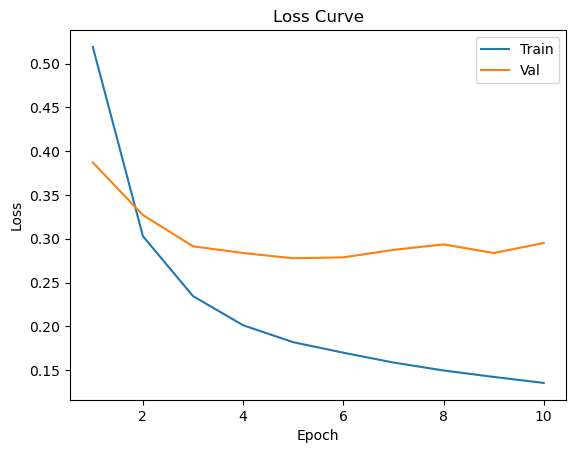

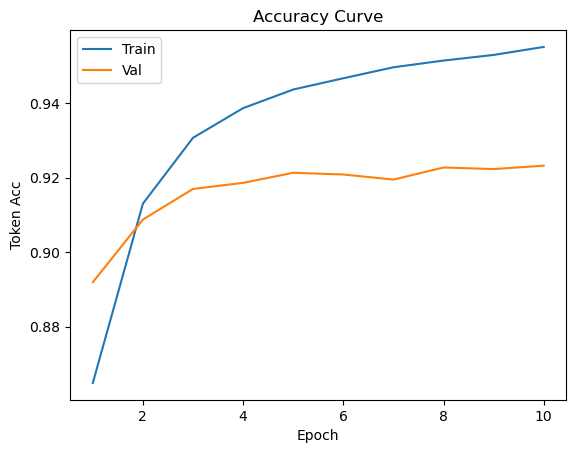

In [7]:
# 7) Plot Losses & Accuracies
plt.figure(); plt.plot(range(1,epochs+1), train_losses, label="Train"); plt.plot(range(1,epochs+1), val_losses, label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve"); plt.show()

plt.figure(); plt.plot(range(1,epochs+1), train_accs, label="Train"); plt.plot(range(1,epochs+1), val_accs, label="Val")
plt.xlabel("Epoch"); plt.ylabel("Token Acc"); plt.legend(); plt.title("Accuracy Curve"); plt.show()


<Figure size 800x800 with 0 Axes>

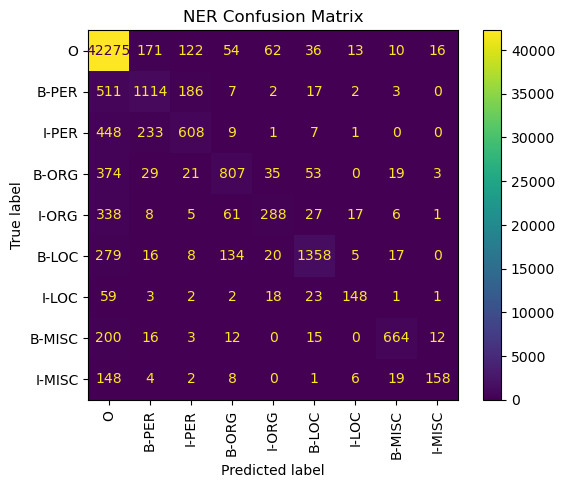

In [8]:
# 8) Confusion Matrix on validation set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for toks, tags, mask in val_loader:
        logits = model(toks, mask)
        pred = logits.argmax(-1)
        valid = tags != -100
        all_preds.extend(pred[valid].cpu().numpy())
        all_labels.extend(tags[valid].cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(id2tag))))
disp = ConfusionMatrixDisplay(cm, display_labels=id2tag)
plt.figure(figsize=(8,8))
disp.plot(include_values=True, xticks_rotation="vertical"); plt.title("NER Confusion Matrix"); plt.show()
